# Training a GBV classifier from a previously labeled dataset

In [1]:
# Used libraries
import pandas as pd
import unicodedata
import numpy as np
import openpyxl
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

In [2]:
# Loading the labeled data
file_path = 'gbv_df.xlsx'
gbv_df = pd.read_excel(file_path)

# Inspect
print(gbv_df.head())

                                                link state  \
0  https://web.archive.org/web/20200901174745/htt...  CHIH   
1  https://web.archive.org/web/20200721132743/htt...  CHIH   
2    http://laopcion.com.mx/noticia/98812?archivo=si  CHIH   
3  https://web.archive.org/web/20200901181614/htt...  CHIH   
4  https://web.archive.org/web/20200901184921/htt...  CHIH   

                                               title      frame  
0  Imparte fiscalía pláticas preventivas a emplea...   Temático  
1  La atropella su pareja y la deja lesionada al ...  Episódico  
2  Detienen a chofer de camión urbano por hostiga...  Episódico  
3  Inaugura Duarte Centro de Salud y Albergue Cie...   Temático  
4  Presentan la conferencia La grandeza de ser mu...   Temático  


In [4]:
# Preprocessing function
def preprocess_text(text):
    # To avoid bugs... 
    text = text.lower()
    # Remove non-alphabetical characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply preprocessing to the 'title' column
gbv_df['cleaned_title'] = gbv_df['title'].apply(preprocess_text)

# Preview of the cleaned text
print(gbv_df[['title', 'cleaned_title']].head())

                                               title  \
0  Imparte fiscalía pláticas preventivas a emplea...   
1  La atropella su pareja y la deja lesionada al ...   
2  Detienen a chofer de camión urbano por hostiga...   
3  Inaugura Duarte Centro de Salud y Albergue Cie...   
4  Presentan la conferencia La grandeza de ser mu...   

                                       cleaned_title  
0  imparte fiscala plticas preventivas a empleado...  
1  la atropella su pareja y la deja lesionada al ...  
2  detienen a chofer de camin urbano por hostigam...  
3  inaugura duarte centro de salud y albergue cie...  
4  presentan la conferencia la grandeza de ser mu...  


In [5]:
# Function to clean frame labels and remove accents
def clean_labels(label):
    # Normalize the text to decompose accents
    label = unicodedata.normalize('NFD', label)
    # Remove diacritics (accents) by filtering characters
    label = ''.join(char for char in label if unicodedata.category(char) != 'Mn')
    # Convert to lowercase and strip whitespace
    label = label.lower().strip()
    return label

# Apply the cleaning function to the 'frame' column
gbv_df['frames'] = gbv_df['frame'].apply(clean_labels)

In [6]:
# Define features (X) and labels (y)
X = gbv_df['cleaned_title']
y = gbv_df['frames']  

# Encode labels if necessary
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # Converts to numerical values
print(label_encoder.classes_)  # Check the mapping

['episodico' 'tematico']


In [7]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")

Training samples: 777, Test samples: 195


In [10]:
# TF-IDF for feature extraction
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed

# Fit the vectorizer on training data and transform both training and test data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF matrix shape (training): {X_train_tfidf.shape}")

TF-IDF matrix shape (training): (777, 1775)


In [11]:
# Train a logistic regression model
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred = logreg.predict(X_test_tfidf)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Accuracy: 0.9128205128205128
Classification Report:
               precision    recall  f1-score   support

   episodico       0.91      0.93      0.92       103
    tematico       0.92      0.89      0.91        92

    accuracy                           0.91       195
   macro avg       0.91      0.91      0.91       195
weighted avg       0.91      0.91      0.91       195



In [12]:
import joblib

# Save the trained model and vectorizer
joblib.dump(logreg, 'logreg_model.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

# Scraping for more news titles

# 8 Columnas

In [13]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import csv

In [14]:
## Successfull scraping

import requests
from bs4 import BeautifulSoup

def extract_titles_and_links(base_url, max_pages=10):
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36"
    }
    results = []

    # Iterate through pages
    for page_number in range(1, max_pages + 1):
        # URL based on page number
        if page_number == 1:
            url = base_url
        else:
            url = f"https://8columnas.com.mx/page/{page_number}/?s=mujer"  # Adjust for pagination
        
        print(f"Fetching: {url}")
        response = requests.get(url, headers=headers)
        
        # Checking for response errors
        if response.status_code != 200:
            print(f"Failed to fetch page: {url}, Status Code: {response.status_code}")
            continue
        
        # Parse the HTML content
        soup = BeautifulSoup(response.content, "html.parser")
        articles = soup.find_all("h3", class_="entry-title")
        
        # Extract titles and links
        for article in articles:
            title_tag = article.find("a", href=True)
            if title_tag:
                title = title_tag.get_text(strip=True)
                link = title_tag["href"]
                results.append({"link": link, "title": title, "state": "edo"})
    
    return results

# Save data to CSV
def save_to_csv(data, filename="8c_titles_mujer.csv"):
    import csv
    with open(filename, mode="w", encoding="utf-8", newline="") as file:
        writer = csv.DictWriter(file, fieldnames=["link", "title", "state"])
        writer.writeheader()
        writer.writerows(data)

# Main Function
if __name__ == "__main__":
    # Base URL includes the keyword
    base_url = "https://8columnas.com.mx/?s=mujer"
    articles = extract_titles_and_links(base_url, max_pages=10)  # Adjust number of pages as needed
    save_to_csv(articles)
    print("Scraping completed and data saved to '8c_titles_mujer.csv'.")


Fetching: https://8columnas.com.mx/?s=mujer
Fetching: https://8columnas.com.mx/page/2/?s=mujer
Fetching: https://8columnas.com.mx/page/3/?s=mujer
Fetching: https://8columnas.com.mx/page/4/?s=mujer
Fetching: https://8columnas.com.mx/page/5/?s=mujer
Fetching: https://8columnas.com.mx/page/6/?s=mujer
Fetching: https://8columnas.com.mx/page/7/?s=mujer
Fetching: https://8columnas.com.mx/page/8/?s=mujer
Fetching: https://8columnas.com.mx/page/9/?s=mujer
Fetching: https://8columnas.com.mx/page/10/?s=mujer
Scraping completed and data saved to '8c_titles_mujer.csv'.


In [ ]:
## Trying with more keywords: "niña", "feminicidio", "violencia+de+género"

import requests
from bs4 import BeautifulSoup
import csv

def extract_titles_and_links(base_url, keyword, max_pages=10):
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36"
    }
    results = []

    # Iterate through pages
    for page_number in range(1, max_pages + 1):
        # Construct URL for each page
        if page_number == 1:
            url = f"{base_url}?s={keyword}"
        else:
            url = f"{base_url}/page/{page_number}/?s={keyword}"
        
        print(f"Fetching: {url}")
        response = requests.get(url, headers=headers)
        
        # Check for response errors
        if response.status_code != 200:
            print(f"Failed to fetch page: {url}, Status Code: {response.status_code}")
            continue
        
        # Parse the HTML content
        soup = BeautifulSoup(response.content, "html.parser")
        articles = soup.find_all("h3", class_="entry-title")
        
        # Extract titles and links
        for article in articles:
            title_tag = article.find("a", href=True)
            if title_tag:
                title = title_tag.get_text(strip=True)
                link = title_tag["href"]
                results.append({"link": link, "title": title, "keyword": keyword})
    
    return results

# Save data to CSV
def save_to_csv(data, filename="8c_titles.csv"):
    with open(filename, mode="w", encoding="utf-8", newline="") as file:
        writer = csv.DictWriter(file, fieldnames=["link", "title", "keyword"])
        writer.writeheader()
        writer.writerows(data)

# Main Function
if __name__ == "__main__":
    # Base URL and keywords
    base_url = "https://8columnas.com.mx"
    keywords = ["mujer", "niña", "feminicidio", "violencia+de+género"] 
    all_results = []

    for keyword in keywords:
        print(f"Fetching articles for keyword: {keyword}")
        results = extract_titles_and_links(base_url, keyword, max_pages=10)
        all_results.extend(results)  # Combine results for all keywords
    
    # Save all results into a single CSV
    save_to_csv(all_results, filename="8c_titles.csv")
    print("Scraping completed and data saved to '8c_titles.csv'.")

Fetching articles for keyword: mujer
Fetching: https://8columnas.com.mx?s=mujer
Fetching: https://8columnas.com.mx/page/2/?s=mujer
Fetching: https://8columnas.com.mx/page/3/?s=mujer
Fetching: https://8columnas.com.mx/page/4/?s=mujer
Fetching: https://8columnas.com.mx/page/5/?s=mujer
Fetching: https://8columnas.com.mx/page/6/?s=mujer
Fetching: https://8columnas.com.mx/page/7/?s=mujer
Fetching: https://8columnas.com.mx/page/8/?s=mujer
Fetching: https://8columnas.com.mx/page/9/?s=mujer
Fetching: https://8columnas.com.mx/page/10/?s=mujer
Fetching articles for keyword: niña
Fetching: https://8columnas.com.mx?s=niña
Fetching: https://8columnas.com.mx/page/2/?s=niña
Fetching: https://8columnas.com.mx/page/3/?s=niña
Fetching: https://8columnas.com.mx/page/4/?s=niña
Fetching: https://8columnas.com.mx/page/5/?s=niña
Fetching: https://8columnas.com.mx/page/6/?s=niña
Fetching: https://8columnas.com.mx/page/7/?s=niña
Fetching: https://8columnas.com.mx/page/8/?s=niña
Fetching: https://8columnas.com.

In [16]:
### Removing "Top read news" that also got fetched articles

import requests
from bs4 import BeautifulSoup
import csv

def extract_titles_and_links(base_url, keyword, max_pages=10):
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36"
    }
    results = []

    # Iterate through pages
    for page_number in range(1, max_pages + 1):
        # Construct URL for each page
        if page_number == 1:
            url = f"{base_url}?s={keyword}"
        else:
            url = f"{base_url}/page/{page_number}/?s={keyword}"
        
        print(f"Fetching: {url}")
        response = requests.get(url, headers=headers)
        
        # Check for response errors
        if response.status_code != 200:
            print(f"Failed to fetch page: {url}, Status Code: {response.status_code}")
            continue
        
        # Parse the HTML content
        soup = BeautifulSoup(response.content, "html.parser")
        articles = soup.find_all("h3", class_="entry-title")
        
        # Extract titles and links
        for article in articles:
            title_tag = article.find("a", href=True)
            if title_tag:
                title = title_tag.get_text(strip=True)
                link = title_tag["href"]
                results.append({"link": link, "title": title, "keyword": keyword})
    
    return results

# Save data to CSV
def save_to_csv(data, filename="8c_titles.csv"):
    # To remove titles that appear on the side as "most popular"
    excluded_titles = [
        "Rinde protesta como presidente de Almoloya de Juárez, Adolfo Solís",
        "Se mantiene en Edoméx tendencia a la baja en homicidio doloso",
        "Petro venderá la residencia del embajador en México para mejorar servicios consulares",
        "TikTok enfrenta investigación de la UE por presunta interferencia en elecciones presidenciales de Rumanía"
    ]

    # Filter out excluded titles
    filtered_data = [row for row in data if row["title"] not in excluded_titles]

    # Write the filtered data to CSV
    with open(filename, mode="w", encoding="utf-8", newline="") as file:
        writer = csv.DictWriter(file, fieldnames=["link", "title", "keyword"])
        writer.writeheader()
        writer.writerows(filtered_data)

# Main Function
if __name__ == "__main__":
    # Base URL and keywords
    base_url = "https://8columnas.com.mx"
    keywords = ["mujer", "niña", "feminicidio", "violencia+de+género"]
    all_results = []

    for keyword in keywords:
        print(f"Fetching articles for keyword: {keyword}")
        results = extract_titles_and_links(base_url, keyword, max_pages=10)
        all_results.extend(results)  # Combine results for all keywords
    
    # Save filtered results to CSV
    save_to_csv(all_results, filename="8c_titles.csv")
    print("Scraping completed, filtered data saved to '8c_titles.csv'.")

Fetching articles for keyword: mujer
Fetching: https://8columnas.com.mx?s=mujer
Fetching: https://8columnas.com.mx/page/2/?s=mujer
Fetching: https://8columnas.com.mx/page/3/?s=mujer
Fetching: https://8columnas.com.mx/page/4/?s=mujer
Fetching: https://8columnas.com.mx/page/5/?s=mujer
Fetching: https://8columnas.com.mx/page/6/?s=mujer
Fetching: https://8columnas.com.mx/page/7/?s=mujer
Fetching: https://8columnas.com.mx/page/8/?s=mujer
Fetching: https://8columnas.com.mx/page/9/?s=mujer
Fetching: https://8columnas.com.mx/page/10/?s=mujer
Fetching articles for keyword: niña
Fetching: https://8columnas.com.mx?s=niña
Fetching: https://8columnas.com.mx/page/2/?s=niña
Fetching: https://8columnas.com.mx/page/3/?s=niña
Fetching: https://8columnas.com.mx/page/4/?s=niña
Fetching: https://8columnas.com.mx/page/5/?s=niña
Fetching: https://8columnas.com.mx/page/6/?s=niña
Fetching: https://8columnas.com.mx/page/7/?s=niña
Fetching: https://8columnas.com.mx/page/8/?s=niña
Fetching: https://8columnas.com.

In [17]:
# Read the existing CSV file
df = pd.read_csv('8c_titles.csv')

# Add the new 'observations' column with the value 'edo' for all rows
df['state'] = 'edo'

# Save the updated DataFrame to the same CSV file
df.to_csv('8c_titles.csv', index=False)

print("Added 'state' column with value 'edo' to the CSV.")

Added 'state' column with value 'edo' to the CSV.


# La Opción de Chihuahua

## Key word: "mujer"

In [20]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
import time
import csv

In [21]:
# Function to fetch titles
def fetch_titles_with_selenium(base_url, keyword, max_pages=10):
    # Set up WebDriver
    options = webdriver.ChromeOptions()
    options.add_argument("--headless")  # Run in headless mode
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
    
    # Construct the initial URL with the keyword
    url = f"{base_url}?q={keyword}&cx=&ie=UTF-8"
    print(f"Fetching: {url}")
    driver.get(url)
    
    titles = []
    current_page = 1

    while current_page <= max_pages:
        try:
            # Wait for the page navigation and content to load
            WebDriverWait(driver, 10).until(
                EC.presence_of_all_elements_located((By.CSS_SELECTOR, "a.gs-title"))
            )
            time.sleep(2)  # Additional wait for safety
            
            # Find all title elements on the current page
            articles = driver.find_elements(By.CSS_SELECTOR, "a.gs-title")
            for article in articles:
                title = article.text
                link = article.get_attribute("href")
                if title and link:  # Ensure both title and link are valid
                    titles.append({"link": link, "title": title, "keyword": keyword, "state": "chih"})
            
            print(f"Fetched titles from page {current_page}.")
            
            # Try to find the next page button dynamically
            try:
                next_button = driver.find_element(By.CSS_SELECTOR, f"div.gsc-cursor-page[aria-label='Página {current_page + 1}']")
                ActionChains(driver).move_to_element(next_button).click().perform()
                current_page += 1
                time.sleep(2)  # Allow time for the next page to load
            except Exception:
                print(f"No more pages available after page {current_page}.")
                break
        
        except Exception as e:
            print(f"Error during scraping on page {current_page}: {e}")
            break
    
    driver.quit()
    return titles

# Save data to CSV
def save_to_csv(data, filename="titles.csv"):
    with open(filename, mode="w", encoding="utf-8", newline="") as file:
        writer = csv.DictWriter(file, fieldnames=["link", "title", "keyword", "state"])
        writer.writeheader()
        writer.writerows(data)

# Successfully save the 100 notes for the keyword "mujer"
if __name__ == "__main__":
    base_url = "https://laopcion.com.mx/buscar.html"
    keyword = "mujer"  # Replace with the desired keyword
    max_pages = 10
    titles = fetch_titles_with_selenium(base_url, keyword, max_pages)
    
    if titles:
        print(f"Fetched {len(titles)} titles.")
        save_to_csv(titles, f"{keyword}_titles.csv")
        print(f"Data saved to '{keyword}_titles.csv'.")
    else:
        print("No titles were fetched.")

Fetching: https://laopcion.com.mx/buscar.html?q=mujer&cx=&ie=UTF-8
Fetched titles from page 1.
Fetched titles from page 2.
Fetched titles from page 3.
Fetched titles from page 4.
Fetched titles from page 5.
Fetched titles from page 6.
Fetched titles from page 7.
Fetched titles from page 8.
Fetched titles from page 9.
Fetched titles from page 10.
No more pages available after page 10.
Fetched 100 titles.
Data saved to 'mujer_titles.csv'.


## Key words: "niña" and "Violencia de género"

In [23]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import csv
from fake_useragent import UserAgent

In [ ]:
# Function to fetch titles
def fetch_titles_with_selenium(base_url, keyword, max_pages=10):
    # Set up WebDriver
    options = webdriver.ChromeOptions()
    options.add_argument("--headless")  # Run in headless mode
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
    
    # Construct the initial URL with the keyword
    url = f"{base_url}?q={keyword}&cx=&ie=UTF-8"
    print(f"Fetching: {url}")
    driver.get(url)
    
    titles = []
    current_page = 1

    while current_page <= max_pages:
        try:
            # Wait for the page navigation and content to load
            WebDriverWait(driver, 10).until(
                EC.presence_of_all_elements_located((By.CSS_SELECTOR, "a.gs-title"))
            )
            time.sleep(2)  # Additional wait for safety
            
            # Find all title elements on the current page
            articles = driver.find_elements(By.CSS_SELECTOR, "a.gs-title")
            for article in articles:
                title = article.text
                link = article.get_attribute("href")
                if title and link:  # Ensure both title and link are valid
                    titles.append({"link": link, "title": title, "keyword": keyword, "state": "chih"})
            
            print(f"Fetched titles from page {current_page}.")
            
            # Try to find the next page button dynamically
            try:
                next_button = driver.find_element(By.CSS_SELECTOR, f"div.gsc-cursor-page[aria-label='Página {current_page + 1}']")
                ActionChains(driver).move_to_element(next_button).click().perform()
                current_page += 1
                time.sleep(2)  # Allow time for the next page to load
            except Exception:
                print(f"No more pages available after page {current_page}.")
                break
        
        except Exception as e:
            print(f"Error during scraping on page {current_page}: {e}")
            break
    
    driver.quit()
    return titles

# Save data to CSV
def save_to_csv(data, filename="titles.csv"):
    with open(filename, mode="w", encoding="utf-8", newline="") as file:
        writer = csv.DictWriter(file, fieldnames=["link", "title", "keyword", "state"])
        writer.writeheader()
        writer.writerows(data)

# Main function to fetch for multiple keywords
if __name__ == "__main__":
    base_url = "https://laopcion.com.mx/buscar.html"
    keywords = ["niña", "violencia+de+género"]  # The desired keywords
    max_pages = 10
    
    all_titles = []
    
    for keyword in keywords:
        print(f"Fetching titles for keyword: {keyword}")
        titles = fetch_titles_with_selenium(base_url, keyword, max_pages)
        
        if titles:
            print(f"Fetched {len(titles)} titles for keyword '{keyword}'.")
            all_titles.extend(titles)
        else:
            print(f"No titles found for keyword '{keyword}'.")
    
    # Save all fetched titles to CSV
    if all_titles:
        save_to_csv(all_titles, "niña_vdg_titles.csv")
        print("Data saved to 'niña_vdg_titles.csv'.")
    else:
        print("No data to save.")

## Keyword: "feminicidio"

In [25]:
# Function to fetch titles
def fetch_titles_with_selenium(base_url, keyword, max_pages=10):
    # Set up WebDriver
    options = webdriver.ChromeOptions()
    options.add_argument("--headless")  # Run in headless mode
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
    
    # Construct the initial URL with the keyword
    url = f"{base_url}?q={keyword}&cx=&ie=UTF-8"
    print(f"Fetching: {url}")
    driver.get(url)
    
    titles = []
    current_page = 1

    while current_page <= max_pages:
        try:
            # Wait for the page navigation and content to load
            WebDriverWait(driver, 10).until(
                EC.presence_of_all_elements_located((By.CSS_SELECTOR, "a.gs-title"))
            )
            time.sleep(2)  # Additional wait for safety
            
            # Find all title elements on the current page
            articles = driver.find_elements(By.CSS_SELECTOR, "a.gs-title")
            for article in articles:
                title = article.text
                link = article.get_attribute("href")
                if title and link:  # Ensure both title and link are valid
                    titles.append({"link": link, "title": title, "keyword": keyword, "state": "chih"})
            
            print(f"Fetched titles from page {current_page}.")
            
            # Try to find the next page button dynamically
            try:
                next_button = driver.find_element(By.CSS_SELECTOR, f"div.gsc-cursor-page[aria-label='Página {current_page + 1}']")
                ActionChains(driver).move_to_element(next_button).click().perform()
                current_page += 1
                time.sleep(2)  # Allow time for the next page to load
            except Exception:
                print(f"No more pages available after page {current_page}.")
                break
        
        except Exception as e:
            print(f"Error during scraping on page {current_page}: {e}")
            break
    
    driver.quit()
    return titles

# Save data to CSV
def save_to_csv(data, filename="titles.csv"):
    with open(filename, mode="w", encoding="utf-8", newline="") as file:
        writer = csv.DictWriter(file, fieldnames=["link", "title", "keyword", "state"])
        writer.writeheader()
        writer.writerows(data)

# Main function to scrape "feminicidio" titles
if __name__ == "__main__":
    base_url = "https://laopcion.com.mx/buscar.html"
    keyword = "feminicidio"  # Fetch for "feminicidio"
    max_pages = 10
    titles = fetch_titles_with_selenium(base_url, keyword, max_pages)
    
    if titles:
        print(f"Fetched {len(titles)} titles.")
        save_to_csv(titles, f"{keyword}_titles.csv")
        print(f"Data saved to '{keyword}_titles.csv'.")
    else:
        print("No titles were fetched.")

Fetching: https://laopcion.com.mx/buscar.html?q=feminicidio&cx=&ie=UTF-8
Fetched titles from page 1.
Fetched titles from page 2.
Fetched titles from page 3.
No more pages available after page 3.
Fetched 20 titles.
Data saved to 'feminicidio_titles.csv'.


### News for "La Opción de Chihuahua"

In [36]:
import pandas as pd

# List of CSV files to combine
csv_files = ["feminicidio_titles.csv", "mujer_titles.csv", "niña_vdg_titles.csv"]

# List to store DataFrames
dfs = []

# Read and append each CSV file into the list of DataFrames
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)

# Concatenate all DataFrames into one
combined_df = pd.concat(dfs, ignore_index=True)

# Save the combined DataFrame to a new CSV file
combined_df.to_csv("loc_titles.csv", index=False)

print("All titles have been combined into 'loc_titles.csv'.")

All titles have been combined into 'loc_titles.csv'.


### Merging "8 Columnas" and "La Opción de Chihuahua" articles

In [37]:
import pandas as pd

# List of CSV files to combine
csv_files = ["8c_titles.csv", "loc_titles.csv"]

# List to store DataFrames
dfs = []

# Read and append each CSV file into the list of DataFrames
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)

# Concatenate all DataFrames into one
combined_df = pd.concat(dfs, ignore_index=True)

# Save the combined DataFrame to a new CSV file
combined_df.to_csv("combined_titles.csv", index=False)

print("All titles have been combined into 'combined_titles.csv'.")

All titles have been combined into 'combined_titles.csv'.


# Testing the classifier

In [38]:
import pandas as pd
import joblib

In [39]:
# Load the trained model and vectorizer
logreg = joblib.load('logreg_model.pkl')  # Load the logistic regression model
tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')  # Load the TF-IDF vectorizer

# Load the combined CSV file with titles
df = pd.read_csv("combined_titles.csv")

# Ensure there is a 'title' column in the DataFrame
if 'title' not in df.columns:
    raise ValueError("The 'title' column is missing from the CSV file.")

# Transform the titles using the same vectorizer that was used during training
X = tfidf_vectorizer.transform(df['title'])

# Apply the model to predict the class (e.g., 'episodico' or 'temático')
predictions = logreg.predict(X)

# Add the predictions to the DataFrame
df['predicted_class'] = predictions

# Save the results with predictions to a new CSV file
df.to_csv("classified_titles.csv", index=False)

print("Predictions have been applied and saved to 'classified_titles.csv'.")

Predictions have been applied and saved to 'classified_titles.csv'.


In [40]:
# Load the classified titles CSV file
df = pd.read_csv('classified_titles.csv')

In [41]:
df.tail(100)

,link,title,keyword,state,predicted_class
760,https://laopcion.com.mx/juarez/cierra-el-viern...,Cierra el viernes convocatoria para participar...,niña,chih,1
761,https://laopcion.com.mx/nacional/internan-a-ni...,Internan a niña rusa en un centro de menores p...,niña,chih,0
762,https://laopcion.com.mx/espectaculos/le-cumple...,Le cumple Tatiana último deseo a niña con cáncer,niña,chih,1
763,https://laopcion.com.mx/amp/nacional/expulsan-...,Expulsan a niña con VIH de una primaria en Tab...,niña,chih,0
764,https://laopcion.com.mx/espectaculos/apuesta-n...,Apuesta nina rubín por su desarrollo en teatro,niña,chih,0
...,...,...,...,...,...
855,https://www.laopcion.com.mx/local/relatan-en-h...,Relatan en Historias Compartidas 22 mujeres ví...,violencia+de+género,chih,1
856,https://laopcion.com.mx/local/aprueban-la-incl...,Aprueban la inclusión de la Violencia Vicaria ...,violencia+de+género,chih,1
857,https://laopcion.com.mx/local/unen-esfuerzos-t...,Unen esfuerzos titulares de la Comisión Interi...,violencia+de+género,chih,1
858,https://laopcion.com.mx/juarez/fortalecen-capa...,Fortalecen capacidades en acompañamiento juríd...,violencia+de+género,chih,1


In [42]:
prediction_counts

NameError: name 'prediction_counts' is not defined

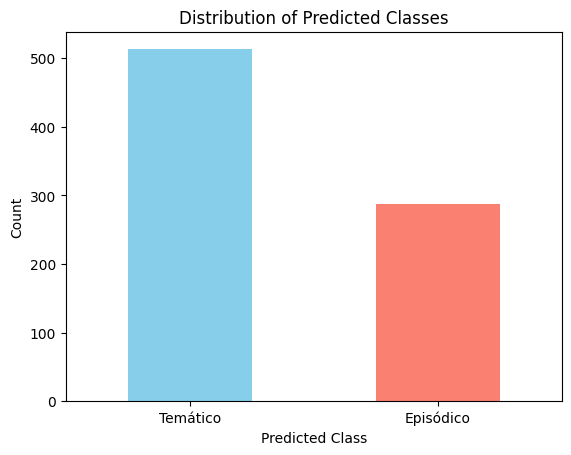

In [151]:
import matplotlib.pyplot as plt

# Count how many articles belong to each predicted class
prediction_counts = df['predicted_class'].value_counts()

# Create a bar plot
prediction_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Predicted Classes')
plt.xticks(ticks=[1, 0], labels=['Episódico', 'Temático'], rotation=0)
plt.xlabel('Predicted Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [176]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# List Spanish prepositions
spanish_stopwords = {
    'a', 'ante', 'bajo', 'cabe', 'con', 'contra', 'de', 'desde', 'en', 'entre', 'dan', 'fue',
    'hacia', 'hasta', 'para', 'por', 'según', 'sin', 'so', 'sobre', 'tras', 'le', 'lo', 'como', 'opción', 'Chihuahua', 'chihuahua',
    'el', 'la', 'los', 'las', 'y', 'una', 'unas', 'un', 'unos', 'del', 'al', 'sí', 'si', 'e', 'es', 'que', 'se'
}

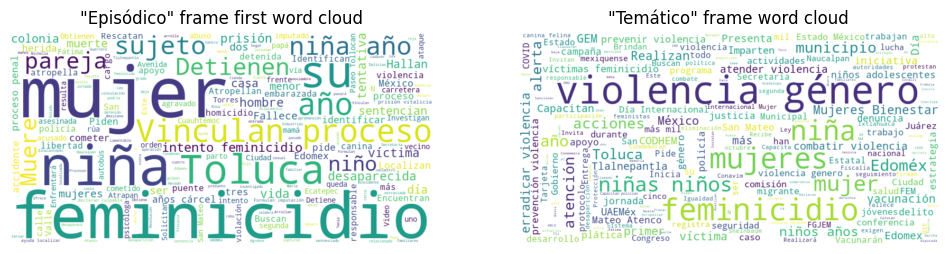

In [177]:
# Function to filter out prepositions from text
def remove_prepositions(text, spanish_stopwords):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in spanish_stopwords]
    return ' '.join(filtered_words)

# Filter the data for each category
episodico_titles = df[df['predicted_class'] == 0]['title']
tematico_titles = df[df['predicted_class'] == 1]['title']

# Combine all titles into one text for each category
episodico_text = ' '.join(episodico_titles)
tematico_text = ' '.join(tematico_titles)

# Remove prepositions from text
episodico_text = remove_prepositions(episodico_text, spanish_stopwords)
tematico_text = remove_prepositions(tematico_text, spanish_stopwords)

# Generate word clouds
episodico_wc = WordCloud(width=800, height=400, background_color='white').generate(episodico_text)
tematico_wc = WordCloud(width=800, height=400, background_color='white').generate(tematico_text)

# Display word clouds
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(episodico_wc, interpolation='bilinear')
plt.title('"Episódico" frame first word cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(tematico_wc, interpolation='bilinear')
plt.title('"Temático" frame word cloud')
plt.axis('off')

plt.show()

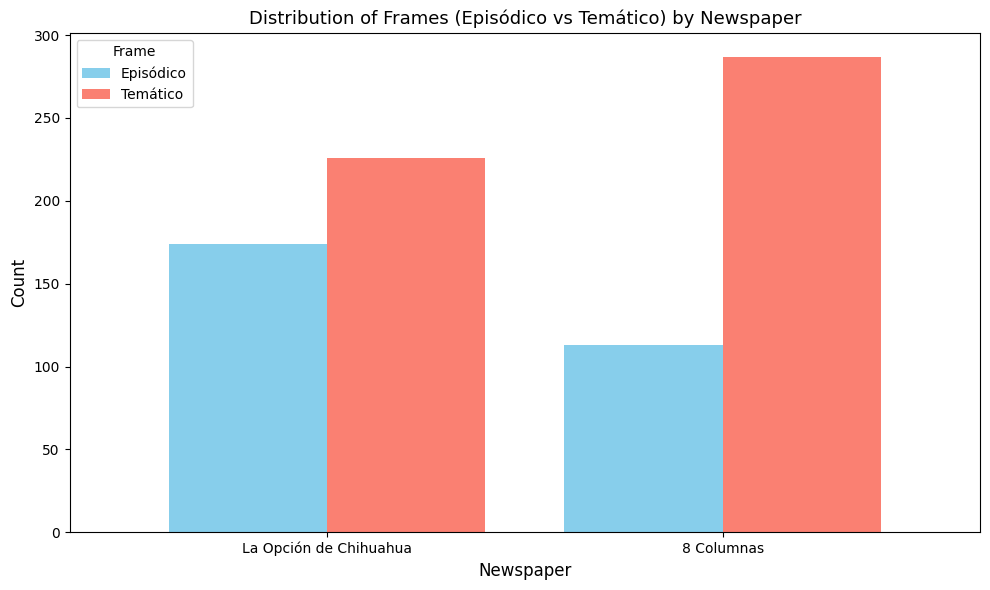

In [166]:
# Define the mapping for the state labels
state_label_mapping = {
    "edo": "8 Columnas",
    "chih": "La Opción de Chihuahua"
}

# Apply the mapping to the index
state_frame_counts = df.groupby(['state', 'frame']).size().unstack(fill_value=0)
state_frame_counts.index = state_frame_counts.index.map(state_label_mapping)

# Plot the updated counts
state_frame_counts.plot(kind="bar", figsize=(10, 6), color=["skyblue", "salmon"], width=0.8)

plt.title("Distribution of Frames (Episódico vs Temático) by Newspaper", fontsize=13)
plt.xlabel("Newspaper", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=0)
plt.legend(title="Frame", fontsize=10)
plt.tight_layout()
plt.show()